In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import HTML

In [2]:
import numpy as np

import torch
from torch.utils.data import Subset

In [3]:
from lib.dataset import unpack_drawings
from lib.dataset import get_n_points, cut_strokes
from lib.dataset import get_dataset, get_train_val_idxs, get_batches
from lib.dataset import strokes_to_points, points_to_strokes
from lib.dataset import END_OF_STROKE_VALUE, PADDING_VALUE
from lib.plot import get_canvas, plot, get_animation
from lib.model import LSTM, evaluate, generate, masked_mse_loss, train

# Load and show dataset

In [4]:
dataset = unpack_drawings('./data/The Eiffel Tower.bin')
dataset = list(dataset)

In [5]:
good_drawings, bad_drawings = [], []
for item in dataset:
    if item['recognized']:
        good_drawings.append(item['image'])
    else:
        bad_drawings.append(item['image'])

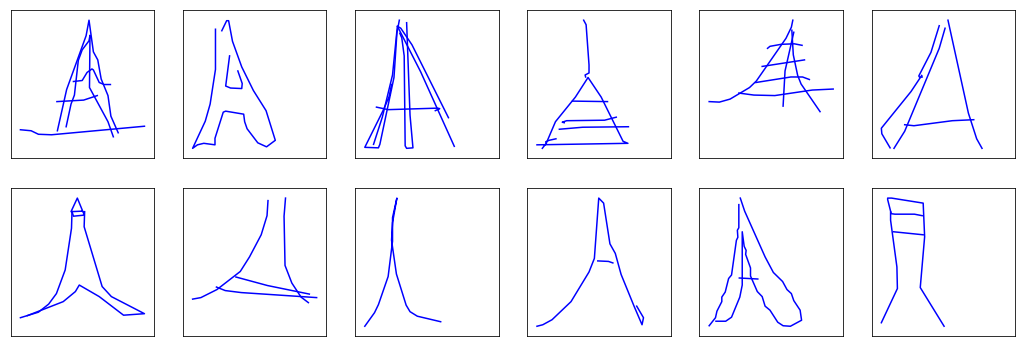

In [6]:
fig, axarr = get_canvas(2, 6)

for i, ax in enumerate(axarr.flatten()):
    plot(good_drawings[i], color='b', ax=ax)

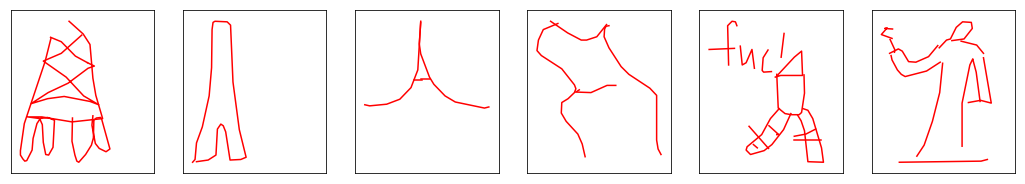

In [7]:
fig, axarr = get_canvas(1, 6)

for i, ax in enumerate(axarr.flatten()):
    plot(bad_drawings[i], color='r', ax=ax)

In [8]:
%%capture
idx = np.random.choice(range(len(good_drawings)))
anim = get_animation(good_drawings[idx])

In [9]:
HTML(anim.to_html5_video())

In [10]:
anim.save('effeil.gif', dpi=80, writer='imagemagick')

# Create pytorch dataset

In [11]:
drawings = [drawing for drawing in good_drawings if 10 <= get_n_points(drawing) <= 50]
ds = get_dataset(drawings)

torch.Size([123453, 71, 2]) torch.Size([123453, 71, 2]) tensor([71, 70, 69,  ..., 10, 10, 10], dtype=torch.int32)


In [12]:
train_idxs, val_idxs = get_train_val_idxs(len(ds), sample_ratio=1)

train_ds = Subset(ds, train_idxs)
val_ds = Subset(ds, val_idxs)

len(train_ds), len(val_ds)

(92420, 31033)

In [13]:
# Debug
train_batches = get_batches(train_ds, batch_size=3)
data_batch, labels_batch, lens_batch = next(iter(train_batches))
data_batch.shape, labels_batch.shape, lens_batch.shape

(torch.Size([71, 3, 2]), torch.Size([71, 3, 2]), torch.Size([3]))

# Train

In [14]:
batch_size = 2048
n_hidden = 64
n_layers = 1
dropout = 0.3 if n_layers > 1 else 0

lstm = LSTM(batch_size, n_hidden, n_layers, dropout)
if torch.cuda.is_available():
    lstm = lstm.cuda()

criterion = masked_mse_loss
optimizer = torch.optim.Adam(lstm.parameters(), 5e-3)

In [15]:
train(lstm, optimizer, criterion, train_ds, val_ds, batch_size, epochs=100, epochs_between_evals=5)

epoch:   1   train_loss: 4256.58   val_loss: 4142.16
epoch:   5   train_loss: 3259.22   val_loss: 3167.75
epoch:  10   train_loss: 3034.67   val_loss: 2953.37
epoch:  15   train_loss: 3051.53   val_loss: 2969.29
epoch:  20   train_loss: 2914.17   val_loss: 2835.90
epoch:  25   train_loss: 2896.68   val_loss: 2819.07
epoch:  30   train_loss: 2819.74   val_loss: 2745.74
epoch:  35   train_loss: 2775.66   val_loss: 2703.59
epoch:  40   train_loss: 2781.53   val_loss: 2710.14
epoch:  45   train_loss: 2789.64   val_loss: 2718.06
epoch:  50   train_loss: 2783.89   val_loss: 2712.89
epoch:  55   train_loss: 2766.40   val_loss: 2696.02
epoch:  60   train_loss: 2778.75   val_loss: 2708.45
epoch:  65   train_loss: 2750.73   val_loss: 2682.14
epoch:  70   train_loss: 2747.57   val_loss: 2679.57
epoch:  75   train_loss: 2745.14   val_loss: 2677.78
epoch:  80   train_loss: 2737.77   val_loss: 2671.14
epoch:  85   train_loss: 2745.26   val_loss: 2679.81
epoch:  90   train_loss: 2755.40   val_loss: 2

In [16]:
torch.save(lstm.state_dict(), 'model1.pth')

In [17]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-3

In [18]:
train(lstm, optimizer, criterion, train_ds, val_ds, batch_size, epochs=200, epochs_between_evals=20)

epoch:   1   train_loss: 2598.42   val_loss: 2542.67
epoch:  20   train_loss: 2567.15   val_loss: 2513.73
epoch:  40   train_loss: 2562.04   val_loss: 2509.28
epoch:  60   train_loss: 2558.54   val_loss: 2506.50
epoch:  80   train_loss: 2555.29   val_loss: 2504.00
epoch: 100   train_loss: 2548.80   val_loss: 2498.46
epoch: 120   train_loss: 2542.44   val_loss: 2493.14
epoch: 140   train_loss: 2541.94   val_loss: 2493.49
epoch: 160   train_loss: 2540.30   val_loss: 2492.61
epoch: 180   train_loss: 2548.24   val_loss: 2500.81
epoch: 200   train_loss: 2542.91   val_loss: 2496.31


In [19]:
train(lstm, optimizer, criterion, train_ds, val_ds, batch_size, epochs=200, epochs_between_evals=20)

epoch:   1   train_loss: 2542.57   val_loss: 2496.06
epoch:  20   train_loss: 2539.33   val_loss: 2493.57
epoch:  40   train_loss: 2536.77   val_loss: 2491.69
epoch:  60   train_loss: 2536.07   val_loss: 2491.61
epoch:  80   train_loss: 2535.20   val_loss: 2491.29
epoch: 100   train_loss: 2532.48   val_loss: 2488.97
epoch: 120   train_loss: 2530.44   val_loss: 2487.31
epoch: 140   train_loss: 2528.04   val_loss: 2485.50
epoch: 160   train_loss: 2525.72   val_loss: 2483.73
epoch: 180   train_loss: 2523.17   val_loss: 2481.68
epoch: 200   train_loss: 2520.90   val_loss: 2480.00


In [20]:
torch.save(lstm.state_dict(), 'model2.pth')

In [21]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-4

In [22]:
train(lstm, optimizer, criterion, train_ds, val_ds, batch_size, epochs=200, epochs_between_evals=20)

epoch:   1   train_loss: 2374.38   val_loss: 2343.06


KeyboardInterrupt: 

In [ ]:
torch.save(lstm.state_dict(), 'model3.pth')

In [ ]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-5

In [ ]:
train(lstm, optimizer, criterion, train_ds, val_ds, batch_size, epochs=200, epochs_between_evals=20)

In [ ]:
torch.save(lstm.state_dict(), 'model4.pth')

# Predict

In [ ]:
map_location = 'cuda' if torch.cuda.is_available() else 'cpu'
lstm.load_state_dict(torch.load('model4.pth', map_location=map_location))

In [23]:
n_initial_points = 3

idx = np.random.choice(len(val_ds))
points = val_ds[idx][0]
initial_points = points[:n_initial_points]

In [24]:
pred_points = generate(lstm, initial_points, 30)

In [25]:
%%capture

from lib.plot import get_animation

strokes = points_to_strokes(points)
anim = get_animation(strokes)

cut_drawing = cut_strokes(strokes, len(initial_points))
cut_anim = get_animation(cut_drawing)

pred_strokes = points_to_strokes(pred_points)
pred_anim = get_animation(pred_strokes)

In [26]:
# Initial points for drawing
HTML(cut_anim.to_html5_video())

In [27]:
# Ground truth drawing
HTML(anim.to_html5_video())

In [28]:
# Generated drawing
HTML(pred_anim.to_html5_video())